# Train a Model to Predict Formation Energy using the OQMD
This notebook recreates a 2016 paper by [Ward et al.](https://www.nature.com/articles/npjcompumats201628) on predicting the formation enthalpy of materials based on their composition. We will use the [Materials Data Facility](http://materialsdatafacility.org) to retrieve a training set from the the [OQMD](http://oqmd.org), compute features based on the composition of each entry, and then train a random forest model.

This example was last updated for Matminer v.0.2.6

In [1]:
%matplotlib inline
from matminer.data_retrieval import retrieve_MDF
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.utils.conversions import str_to_composition
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold

Settings to change

In [2]:
quick_demo = True # Whether to run an faster version of this demo. 
# The full OQMD model takes about a hour to test and ~8GB of RAM
version_number = 3 # Current version number of the OQMD data on MDF

## Load Training Set
Ward _et al._ trained their machine learning models on the formation enthalpies of crystalline compounds form the [OQMD](oqmd.org). Here, we extract the data using the copy of the OQMD available through the MDF

### Download the Data
We first create a `Forge` instance, which simplifies performing search queries against the MDF.

The first step is to create a tool for reading from the MDF's search index.

In [3]:
mdf = retrieve_MDF.MDFDataRetrieval(anonymous=True)

Then, we assemble a query that gets only the converged static calculations from the OQMD. 

In [4]:
query_string = 'mdf.source_name:oqmd_v{0} AND (oqmd_v{0}.configuration:static OR oqmd_v{0}.configuration:standard) AND dft.converged:True'.format(version_number)
if quick_demo:
    query_string += " AND mdf.scroll_id:<10000"

In [5]:
data = mdf.get_dataframe_by_query(query_string, unwind_arrays=False)

This tool creates a DataFrame object with the metadata for each entry in the OQMD

In [6]:
data.head(2)

,crystal_structure.cross_reference.icsd,crystal_structure.number_of_atoms,crystal_structure.space_group_number,crystal_structure.volume,dft.converged,dft.cutoff_energy,dft.exchange_correlation_functional,files,material.composition,material.elements,...,oqmd_v3.delta_e.units,oqmd_v3.delta_e.value,oqmd_v3.magnetic_moment.units,oqmd_v3.magnetic_moment.value,oqmd_v3.stability.units,oqmd_v3.stability.value,oqmd_v3.total_energy.units,oqmd_v3.total_energy.value,oqmd_v3.volume_pa.units,oqmd_v3.volume_pa.value
0,NaN,9,123,142.7270,True,520.0,PBE,"[{'data_type': 'ASCII text, with very long lin...",Ir2K2O5,"[O, Ir, K]",...,eV/atom,0.222111,bohr/atom,0.231370,eV/atom,1.502803,eV/atom,-4.502302,angstrom^3/atom,15.8586
1,NaN,3,216,69.2541,True,520.0,PBE,"[{'data_type': 'ASCII text, with very long lin...",Gd1Si1Ti1,"[Si, Gd, Ti]",...,eV/atom,-0.248908,bohr/atom,0.566871,eV/atom,NaN,eV/atom,-6.174915,angstrom^3/atom,23.0847


We only need two columns: `delta_e` and `mdf.composition`

In [7]:
data = data[['oqmd_v%d.delta_e.value'%version_number, 'material.composition']]

In [8]:
data.rename(columns={'oqmd_v%d.delta_e.value'%version_number: 'delta_e'}, inplace=True)

### Compile the Training Set
Our next step is to get only the lowest-energy entry for each composition.

In [9]:
data['composition_obj'] = str_to_composition(data['material.composition'])

Create shortcuts for our input and output columns

Remove compounds w/o a `delta_e` measurement.

In [10]:
for k in ['delta_e']:
    data[k] = pd.to_numeric(data[k])

In [11]:
original_count = len(data)
data = data[~ data['delta_e'].isnull()]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 425/4897 entries


Get only the groundstate and each composition

In [12]:
%%time
original_count = len(data)
data['mdf.composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)
data.sort_values('delta_e', ascending=True, inplace=True)
data.drop_duplicates('mdf.composition', keep='first', inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 31/4472 entries
Wall time: 450 ms


Remove outliers

In [13]:
original_count = len(data)
data = data[np.logical_and(data['delta_e'] >= -20, data['delta_e'] <= 5)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 2/4441 entries


## Build an ML model
In this part of the notebook, we build a ML model using [scikit-learn](http://scikit-learn.org/stable/) and evaluate its performance using cross-validation.

### Part 1: Compute Representation
The first step in building a ML model is to convert the raw materials data (here: the composition) into the required input for an ML model: a finite list of quantitative attributes. In this example, we use the "general-purpose" attributes of [Ward *et al* 2016](https://www.nature.com/articles/npjcompumats201628).

In [14]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

Get the feature names

In [15]:
feature_labels = feature_calculators.feature_labels()

Compute the features

In [16]:
%%time
feature_calculators.featurize_dataframe(data, col_id='composition_obj');

Wall time: 15.3 s


,delta_e,material.composition,composition_obj,mdf.composition,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,...,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
2642,-4.103282,F3Ho1,"(F, Ho)",HoF3,2.0,0.790569,0.759147,0.750616,0.750049,0.750001,...,59.750000,67.125000,15.0,2.000000,3.750000,0.000000,2.750000,1.0,0.849023,0.159192
954,-4.031570,F7K1Sc2,"(F, K, Sc)",KSc2F7,3.0,0.734847,0.706070,0.700275,0.700016,0.700000,...,72.200000,80.080000,15.0,1.900000,3.500000,0.200000,0.000000,1.0,0.917619,0.180472
1880,-3.971131,F3Tb1,"(F, Tb)",TbF3,2.0,0.790569,0.759147,0.750616,0.750049,0.750001,...,59.750000,67.125000,15.0,2.000000,3.750000,0.000000,2.250000,1.0,0.874268,0.163925
1505,-3.906945,Ba2F6O1Ti1,"(Ba, F, O, Ti)",Ba2TiOF6,4.0,0.648074,0.609120,0.600524,0.600040,0.600001,...,75.400000,85.160000,15.0,2.000000,3.400000,0.200000,0.000000,1.0,0.908097,0.183659
601,-3.760382,O3Sc1Sm1,"(O, Sc, Sm)",SmScO3,3.0,0.663325,0.614463,0.600984,0.600078,0.600002,...,79.200000,80.640000,12.0,2.000000,2.400000,0.200000,1.200000,1.0,0.724240,0.166582
1111,-3.747751,Ac1Er1O3,"(Ac, Er, O)",AcErO3,3.0,0.663325,0.614463,0.600984,0.600078,0.600002,...,91.000000,94.800000,12.0,2.000000,2.400000,0.200000,2.400000,1.0,0.745613,0.173885
154,-3.691770,Lu2O5Si1,"(Lu, O, Si)",Lu2SiO5,3.0,0.684653,0.639654,0.626314,0.625147,0.625007,...,84.375000,90.468750,12.0,2.000000,2.750000,0.250000,3.500000,1.0,0.691867,0.146000
853,-3.616113,O3Sr1Th1,"(O, Sr, Th)",SrThO3,3.0,0.663325,0.614463,0.600984,0.600078,0.600002,...,97.200000,102.240000,12.0,2.000000,2.400000,0.400000,0.000000,1.0,0.787757,0.177547
697,-3.607038,Al3F12K2Na1,"(Al, F, K, Na)",K2NaAl3F12,4.0,0.698323,0.671265,0.666814,0.666673,0.666667,...,85.666667,94.222222,15.0,1.833333,3.500000,0.000000,0.000000,1.0,0.917619,0.188921
219,-3.606707,F11Na1Zn1Zr2,"(F, Na, Zn, Zr)",NaZr2ZnF11,4.0,0.751295,0.735165,0.733364,0.733334,0.733333,...,65.066667,73.431111,15.0,1.933333,3.666667,0.933333,0.000000,1.0,0.902278,0.162413


In [17]:
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

Generated 145 features
Training set size: 4439x145


Remove entries with `NaN` or `infinite` features

In [18]:
original_count = len(data)
data = data[~ data[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/4439 entries


### Part 2: Tuning Model Hyper-parameters
For brevity, we will only consider one ML algorithm in this example: [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). The "random forest" algorithm works by training many different decision tree models, where each is trained on a different subset of the dataset . Here, we tune one of the major parameters of the algoritm: the number features considered at each split in each decision tree

In [19]:
model = GridSearchCV(RandomForestRegressor(n_estimators=20 if quick_demo else 150, n_jobs=-1),
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.1))

In [20]:
model.fit(data[feature_labels], data['delta_e'])

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(8, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Plot the tuning results. This shows the CV score as a function of the parameter we tuned "max features"

In [21]:
model.best_score_

-0.10894581399139229

Text(0,0.5,'RMSE (eV/atom)')

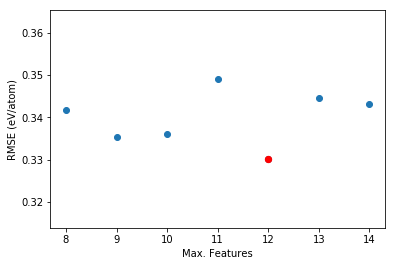

In [22]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

Save our best model

In [23]:
model = model.best_estimator_

### Part 3: Cross-validation Test
Quantify the performance of this model using 10-fold cross-validation

In [24]:
cv_prediction = cross_val_predict(model, data[feature_labels], data['delta_e'], cv=KFold(10, shuffle=True))

Compute aggregate statistics

In [25]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(data['delta_e'], cv_prediction)
    print(scorer, score)

r2_score 0.8684420034019406
mean_absolute_error 0.23234902040573413
mean_squared_error 0.1163988286234959


In [26]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Plot the individual predictions

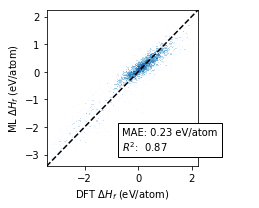

In [27]:
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric(data['delta_e']), cv_prediction, norm=LogNorm(), bins=176, cmap='Blues', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error(data['delta_e'], cv_prediction)
r2 = metrics.r2_score(data['delta_e'], cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)